In [39]:
%pip install numpy pandas tqdm lightgbm seaborn matplotlib plotnine scikit-learn

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import datetime
import hashlib
import os
import gc
pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

In [41]:
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()

2315

In [42]:
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect()

0

In [43]:
test.columns = test.columns.str.replace('-', '_')

In [44]:
selected_features = ['TransactionDT',
 'TransactionAmt','card1','card2','card3','card5',
 'addr1','addr2',
 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
 'D1','D2','D3','D4','D5','D6','D7','D8', 'D9', 'D10','D11','D12','D13','D14','D15','V307',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain', 
 'dist1','id_30','id_31', 'id_32', 'id_33', 'id_34',
 'DeviceType','DeviceInfo',
  'V314', 'V310', 'V127', 'V78', 'V62', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


In [45]:
train = train[selected_features + ['isFraud']]
test = test[selected_features ]

In [46]:
train = train.fillna(-999)
test = test.fillna(-999)

In [47]:
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])

        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp.index = list(temp[col])

        temp = temp[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp)
        test[new_col_name]  = test[col].map(temp)

In [48]:
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)
print("1. bank_type 및 address_match 생성")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())

1. bank_type 및 address_match 생성
                 bank_type     address_match
TransactionID                               
2987000        150.0_142.0  150.0_142.0_87.0
2987001        150.0_102.0  150.0_102.0_87.0
2987002        150.0_166.0  150.0_166.0_87.0
2987003        150.0_117.0  150.0_117.0_87.0
2987004        150.0_102.0  150.0_102.0_87.0
                 bank_type     address_match
TransactionID                               
3663549        150.0_226.0  150.0_226.0_87.0
3663550        150.0_226.0  150.0_226.0_87.0
3663551        150.0_226.0  150.0_226.0_87.0
3663552        150.0_166.0  150.0_166.0_87.0
3663553        150.0_117.0  150.0_117.0_87.0


In [49]:
for col in ['address_match','bank_type']:
    temp = pd.concat([train[[col]], test[[col]]])
    temp[col] = np.where(temp[col].str.contains('nan'), np.nan, temp[col])
    temp = temp.dropna()
    fq_encode = temp[col].value_counts().to_dict()   
    train[col] = train[col].map(fq_encode)
    test[col]  = test[col].map(fq_encode)
print("\n2. 빈도 인코딩 후")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())


2. 빈도 인코딩 후
               bank_type  address_match
TransactionID                          
2987000              309            309
2987001            44082          43735
2987002           101292         101179
2987003            47059          46950
2987004            44082          43735
               bank_type  address_match
TransactionID                          
3663549           531549         526981
3663550           531549         526981
3663551           531549         526981
3663552           101292         101179
3663553            47059          46950


In [50]:
train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match']  = test['address_match']/test['bank_type']
print("\n3. 상대적 비율 계산 후")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())


3. 상대적 비율 계산 후
               bank_type  address_match
TransactionID                          
2987000              309       1.000000
2987001            44082       0.992128
2987002           101292       0.998884
2987003            47059       0.997684
2987004            44082       0.992128
               bank_type  address_match
TransactionID                          
3663549           531549       0.991406
3663550           531549       0.991406
3663551           531549       0.991406
3663552           101292       0.998884
3663553            47059       0.997684


In [51]:
start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train['timeblock'] = train['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)
test['timeblock'] = test['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)

tb = train['timeblock']
print(train.timeblock.head())
train.drop('timeblock', axis=1, inplace=True)
train.insert(0, 'timeblock', tb)

tb = test['timeblock']
print(test.timeblock.head())
test.drop('timeblock', axis=1, inplace=True)
test.insert(0, 'timeblock', tb)

TransactionID
2987000   2017-12-01 00:00:00
2987001   2017-12-01 00:00:01
2987002   2017-12-01 00:01:09
2987003   2017-12-01 00:01:39
2987004   2017-12-01 00:01:46
Name: timeblock, dtype: datetime64[ns]
TransactionID
3663549   2018-07-01 00:00:24
3663550   2018-07-01 00:01:03
3663551   2018-07-01 00:01:50
3663552   2018-07-01 00:01:50
3663553   2018-07-01 00:01:57
Name: timeblock, dtype: datetime64[ns]


In [52]:
def account_start_date(val):
    if np.isnan(val):
        return np.NaN
    else:
        days = int(str(val).split('.')[0])
        return pd.Timedelta(str(days) + ' days')

In [53]:
for i in ['D1', 'D2', 'D4', 'D8', 'D10', 'D15']:
    train['account_start_day'] = train[i].apply(account_start_date)
    test['account_start_day'] = test[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train['account_make_date'] = (train['timeblock'] - train['account_start_day']).dt.date
    test['account_make_date'] = (test['timeblock'] - test['account_start_day']).dt.date

    train['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train['account_make_date']).dt.year) + (100 * pd.to_datetime(train['account_make_date']).dt.month) + (1 * pd.to_datetime(train['account_make_date']).dt.day)
    test['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test['account_make_date']).dt.year) + (100 * pd.to_datetime(test['account_make_date']).dt.month) + (1 * pd.to_datetime(test['account_make_date']).dt.day)

In [54]:
del train['account_make_date']; del test['account_make_date']
del train['account_start_day']; del test['account_start_day']

In [55]:
train['date'] = pd.to_datetime(train['timeblock']).dt.date
test['date'] = pd.to_datetime(test['timeblock']).dt.date

train['year'] = train['timeblock'].dt.year
train['month'] = train['timeblock'].dt.month
train['day'] = train['timeblock'].dt.day
train['dayofweek'] = train['timeblock'].dt.dayofweek
train['hour'] = train['timeblock'].dt.hour
# train['minute'] = train['timeblock'].dt.minute
# train['second'] = train['timeblock'].dt.second

test['year'] = test['timeblock'].dt.year
test['month'] = test['timeblock'].dt.month
test['day'] = test['timeblock'].dt.day
test['dayofweek'] = test['timeblock'].dt.dayofweek
test['hour'] = test['timeblock'].dt.hour
# test['minute'] = test['timeblock'].dt.minute
# test['second'] = test['timeblock'].dt.second

In [56]:
# 이전 거래와의 시간 차이 계산
train['prev_transaction_diff'] = train.groupby('uid')['TransactionDT'].diff().fillna(-1)
test['prev_transaction_diff'] = test.groupby('uid')['TransactionDT'].diff().fillna(-1)

In [57]:
def card_info_hash(x):
    s = (str(int(x['card1']))+
         str(int(x['card2']))+
         str(int(x['card3']))+
         str(x['card4'])+
         str(int(x['card5']))+
         str(x['card6']))
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

def device_hash(x):
    s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1   )
train['device_hash'] = train.apply(lambda x: device_hash(x), axis=1   )

test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1   )
test['device_hash'] = test.apply(lambda x: device_hash(x), axis=1   )

In [58]:
train['V307_diff'] = train['V307'].diff().shift(-1)
train['difference'] = train['V307_diff'] - train['TransactionAmt']

test['V307_diff'] = test['V307'].diff().shift(-1)
test['difference'] = test['V307_diff'] - test['TransactionAmt']

In [59]:
# # 차이 값을 구간으로 나누기 (예: 10개 구간)
# train['difference_bins'] = pd.cut(train['difference'], bins=10)

# # 각 구간별 사기 거래 비율 계산
# fraud_rate_by_bins = train.groupby('difference_bins')['isFraud'].mean().reset_index()

# # 시각화
# plt.figure(figsize=(12, 6))
# sns.barplot(x='difference_bins', y='isFraud', data=fraud_rate_by_bins, palette='viridis')
# plt.xticks(rotation=45)
# plt.xlabel('Difference Bins')
# plt.ylabel('Fraud Rate')
# plt.title('Fraud Rates by Difference Bins')
# plt.show()

In [60]:
total = pd.concat([train,test],axis=0,sort=False)

train['uid2_next_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(-1)
test['uid2_next_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(-1)

train = train.merge(total.groupby(['uid','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid_D1_productCD_Amt_mean','std':'uid_D1_productCD_Amt_std'}), how='left', on = ['uid','account_make_date_D1','ProductCD'])
test = test.merge(total.groupby(['uid','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid_D1_productCD_Amt_mean','std':'uid_D1_productCD_Amt_std'}), how='left', on = ['uid','account_make_date_D1','ProductCD'])
train = train.merge(total.groupby(['uid2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['uid2','ProductCD'])
test = test.merge(total.groupby(['uid2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['uid2','ProductCD'])

In [61]:
del train['uid']; del train['uid2']; del train['bank_type']
del test['uid']; del test['uid2']; del test['bank_type']

In [62]:
# M1부터 M9까지 컬럼 목록
m_columns = [f'M{i}' for i in range(1, 9)]

# M4를 제외한 나머지 컬럼들에 대해 T/F를 1/0으로 변환
mapping = {'T': 1, 'F': 0}
for col in m_columns:
    if col != 'M4':
        train[col] = train[col].map(mapping).fillna(-999)
        test[col] = test[col].map(mapping).fillna(-999)

# M4에 대해 라벨 인코딩 수행
label_encoder = LabelEncoder()
train['M4'] = label_encoder.fit_transform(train['M4'].astype(str))
test['M4'] = label_encoder.transform(test['M4'].astype(str))

In [63]:

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and not np.issubdtype(col_type, np.datetime64):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [64]:
# 적용
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 457.30 MB
Memory usage after optimization is: 181.91 MB
Decreased by 60.2%
Memory usage of dataframe is 388.51 MB
Memory usage after optimization is: 157.05 MB
Decreased by 59.6%


In [65]:
test = test.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)
train = train.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)

In [66]:
# 범주형 열을 숫자형으로 변환
def encode_categorical_columns(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders

# train 데이터 인코딩
train, _ = encode_categorical_columns(train)

# test 데이터 인코딩
test_encoded, _ = encode_categorical_columns(test)

In [67]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)

In [68]:
# DateTime64 타입의 열을 숫자 형식으로 변환하는 함수
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # 초 단위로 변환
    return df

# Assuming X is your feature DataFrame
X = convert_datetime_columns(X)

In [69]:
import lightgbm as lgb

# train, valid split
X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y)

# 데이터 셋 생성
train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_v, label=y_v)

params = {
    'num_leaves': 491,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.3797454081646243,
    'bagging_fraction': 0.4181193142567742,
    'min_data_in_leaf': 106,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.006883242363721497,
    'boosting_type': 'gbdt',
    'bagging_seed': 11,
    'metric': 'auc',
    'verbosity': -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 2024
}

# 모델 학습
callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
clf = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks) # 0.978832   0.978616

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.955967	valid_1's auc: 0.934747
[200]	training's auc: 0.966744	valid_1's auc: 0.943405
[300]	training's auc: 0.975745	valid_1's auc: 0.950924
[400]	training's auc: 0.983435	valid_1's auc: 0.958017
[500]	training's auc: 0.988798	valid_1's auc: 0.96331
[600]	training's auc: 0.992497	valid_1's auc: 0.967094
[700]	training's auc: 0.995156	valid_1's auc: 0.969921
[800]	training's auc: 0.996957	valid_1's auc: 0.971807
[900]	training's auc: 0.998139	valid_1's auc: 0.973073
[1000]	training's auc: 0.998867	valid_1's auc: 0.974193
[1100]	training's auc: 0.999324	valid_1's auc: 0.974991
[1200]	training's auc: 0.999597	valid_1's auc: 0.975677
[1300]	training's auc: 0.999759	valid_1's auc: 0.976303
[1400]	training's auc: 0.999858	valid_1's auc: 0.976793
[1500]	training's auc: 0.999917	valid_1's auc: 0.977137
[1600]	training's auc: 0.999954	valid_1's auc: 0.977385
[1700]	training's auc: 0.999974	valid_1's auc: 0.977

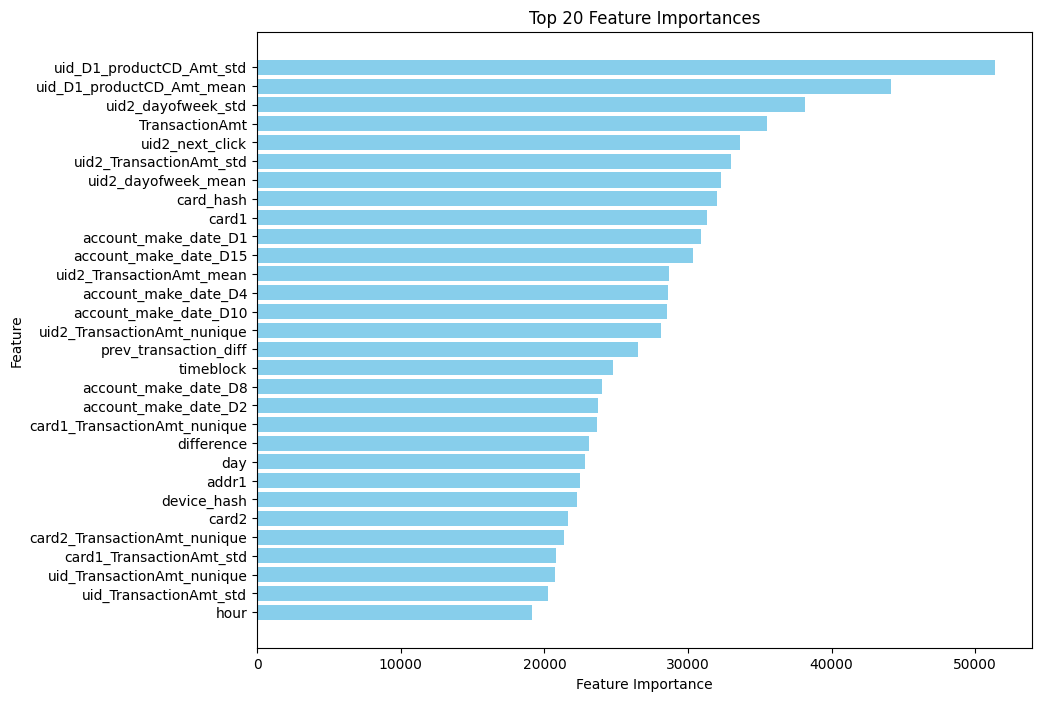

In [70]:
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬하고 상위 20개 피처 선택
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(30)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()

In [71]:
# test_encoded 데이터프레임의 DateTime64 타입 열 변환
test_encoded = convert_datetime_columns(test_encoded)

# 예측 수행
preds = clf.predict(test_encoded)

# 결과 저장
result = pd.read_csv("sample_submission.csv")
result['isFraud'] = preds
result.to_csv('result.csv', index=False)

In [72]:
def print_columns(df):
    print("Columns in the DataFrame:")
    print(", ".join(df.columns))

print_columns(test_encoded)
print_columns(train)

Columns in the DataFrame:
timeblock, TransactionDT, TransactionAmt, card1, card2, card3, card5, addr1, addr2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, ProductCD, card4, card6, P_emaildomain, R_emaildomain, dist1, id_34, V314, V310, V127, V78, V62, M1, M2, M3, M4, M5, M6, M7, M8, card1_TransactionAmt_mean, card1_TransactionAmt_std, card1_TransactionAmt_nunique, card2_TransactionAmt_mean, card2_TransactionAmt_std, card2_TransactionAmt_nunique, card3_TransactionAmt_mean, card3_TransactionAmt_std, card3_TransactionAmt_nunique, card5_TransactionAmt_mean, card5_TransactionAmt_std, card5_TransactionAmt_nunique, uid_TransactionAmt_mean, uid_TransactionAmt_std, uid_TransactionAmt_nunique, uid2_TransactionAmt_mean, uid2_TransactionAmt_std, uid2_TransactionAmt_nunique, address_match, account_make_date_D1, account_make_date_D2, account_make_date_D4, account_make_date_D8, account_make_date_D10, account_make_date_D

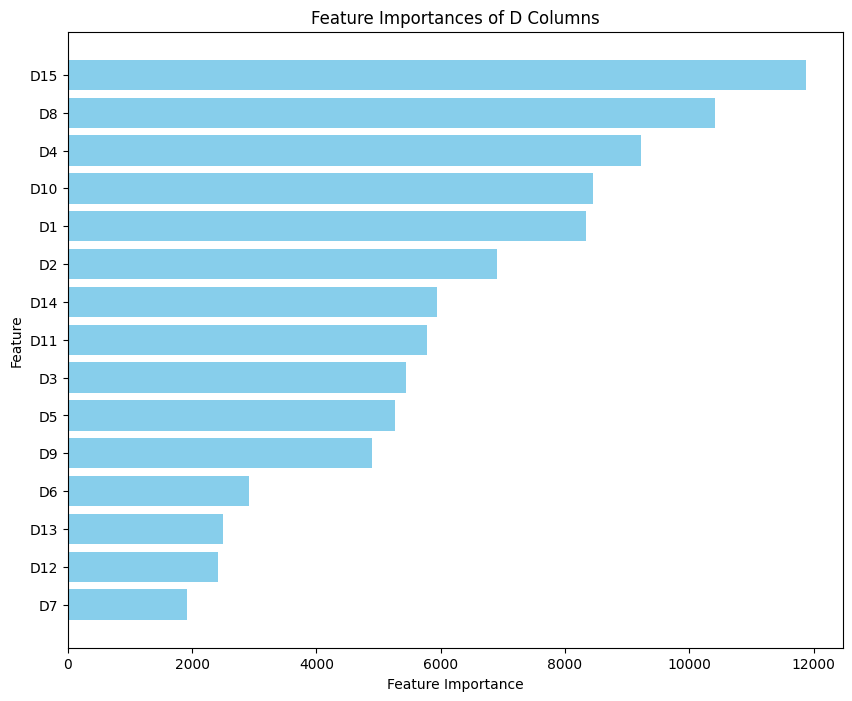

In [73]:
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 'D'로 시작하는 피처만 필터링
d_features = importance_df[importance_df['feature'].str.startswith('D')]

# 중요도 순으로 정렬
d_features = d_features.sort_values(by='importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(d_features['feature'], d_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of D Columns')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()

In [74]:
uid2_columns = train.filter(like='uid2').copy()
uid2_columns

c:\Users\USER\Desktop\광인사\2_Project\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_nunique,uid2_next_click,uid2_dayofweek_mean,uid2_dayofweek_std
0,193.0000,176.12500,2,-6286225.0,5.000000,1.414062
1,240.0000,503.75000,53,-413142.0,3.000000,1.776367
2,65.6875,55.15625,23,-864538.0,3.244141,1.569336
3,113.0625,211.75000,109,-8498.0,3.013672,1.973633
4,50.0000,NaN,1,NaN,4.000000,NaN
...,...,...,...,...,...,...
590535,74.6875,49.09375,16,NaN,3.544922,1.787109
590536,212.1250,105.75000,9,NaN,2.390625,1.900391
590537,126.0625,162.00000,207,NaN,2.958984,1.946289
590538,159.6250,416.25000,239,NaN,2.912109,1.958984
